In [1]:
%%capture
import tensorflow as tf
from tensorflow import keras
from scipy.io import loadmat
from IPython.display import HTML, display
from tensorflow.keras import regularizers
import os
! pip install tabulate
import tabulate
import time
import numpy as np
import gc
from tensorflow.keras.models import model_from_json
!pip install tqdm
!pip install h5py
from tqdm import tqdm_notebook
import matplotlib.pyplot as plt
from tensorflow.keras import backend as K
from sklearn.metrics import r2_score
from sklearn import preprocessing

In [2]:
def scale(x):

    return (x - np.mean(x)) / np.std(x)

In [3]:
def preprocess(x):
    
    return x[:,:,:int(0.75*x.shape[2])]

In [4]:
os.chdir("/home/pk2573/Capstone_Data/Re1243Fr20_coarse8")
u = preprocess(scale(loadmat('u_F_xyz_T1.mat')["u_F"]))
v = preprocess(scale(loadmat('v_F_xyz_T1.mat')["v_F"]))
w = preprocess(scale(loadmat('w_F_xyz_T1.mat')["w_F"]))
tau_12 = preprocess(scale(loadmat('tau12_xyz_T1.mat')["tau12"]))
tau_13 = preprocess(scale(loadmat('tau13_xyz_T1.mat')["tau13"]))
tau_23 = preprocess(scale(loadmat('tau23_xyz_T1.mat')["tau23"]))

### 1. Generate Input datasets

In [5]:
x = np.array([u, v, w])
x = np.transpose(x, [1, 2, 3, 0])

del u 
del v
del w
gc.collect()

11

In [6]:
def generate_data(size, data):
    
    size_x = size[0] 
    size_y = size[1] 
    size_z = size[2] 
    data = np.pad(data, ((size_x, size_x), (size_y, size_y), (size_z, size_z), (0,0)), 'constant', constant_values = 0)
    
    sample = []
    y_tau_12 = []
    y_tau_13 = []
    y_tau_23 = []

    for i in range(size_x, data.shape[0] - size_x):
        for j in range(size_y, data.shape[1] - size_y):
            for k in range(size_z, data.shape[2] - size_z):
                sample.append(data[i - size_x: i + size_x + 1, j - size_y: j + size_y + 1, k - size_z: k + size_z + 1, :])
                y_tau_12.append(tau_12[i - size_x][j - size_y][k - size_z])
                y_tau_13.append(tau_13[i - size_x][j - size_y][k - size_z])
                y_tau_23.append(tau_23[i - size_x][j - size_y][k - size_z])

    data = np.stack(sample, axis = 0)
    y_tau_12 = np.array(y_tau_12)
    y_tau_13 = np.array(y_tau_13)
    y_tau_23 = np.array(y_tau_23)

    del sample
    gc.collect()
    
    return  data, [(y_tau_12, "tau_12"), (y_tau_13, "tau_13"), (y_tau_23, "tau_23")]

### 2. Build Model 

In [7]:
class DNN(object):
    
    def __init__(self, activation, x_train, y_train, epochs, batch_size, input_shape, val_split, initializer):
        self.activation = activation
        self.x_train = x_train
        self.y_train = y_train
        self.epochs = epochs
        self.batch_size = batch_size
        self.input_shape = input_shape
        self.val_split = val_split
        self.initializer = initializer
        
        pass 
    
    def create_model(self):
        model = keras.Sequential([
            tf.keras.layers.Flatten(input_shape = self.input_shape),
            tf.keras.layers.Dense(128, 
                             activation = self.activation,
                             kernel_initializer = self.initializer),
            tf.keras.layers.Dropout(0.2),
            tf.keras.layers.Dense(64, 
                             activation = self.activation,
                             kernel_initializer = self.initializer),
            tf.keras.layers.Dropout(0.2),
            tf.keras.layers.Dense(32, 
                             activation = self.activation,
                             kernel_initializer = self.initializer),
            tf.keras.layers.Dense(1)
        ])
        
        return model
    
    def callbacks(self):
        early_stopping = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss',
                                               min_delta = 0.001,
                                               patience = 0,
                                               verbose = 0)
        
        return early_stopping
    
    def run_model(self):
        model = self.create_model()
        model.compile(optimizer = tf.train.AdamOptimizer(), 
              loss = "mse")
            
        history = model.fit(self.x_train, self.y_train, 
                    epochs = self.epochs, 
                    validation_split = self.val_split, 
                    batch_size =  self.batch_size,
                    verbose = 0)
        
        return history, model

### 3. Run Model

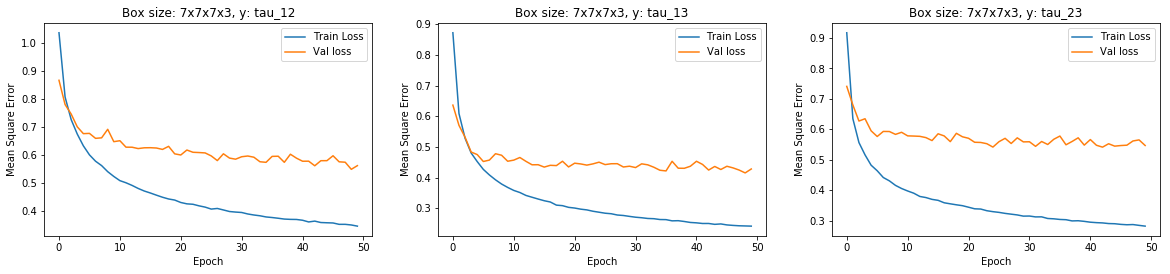

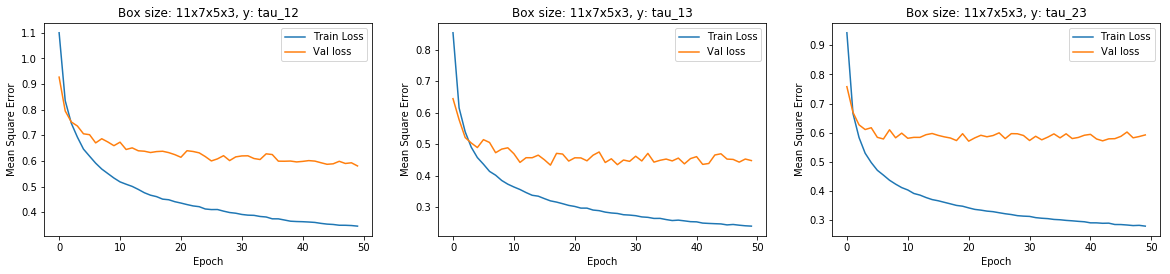

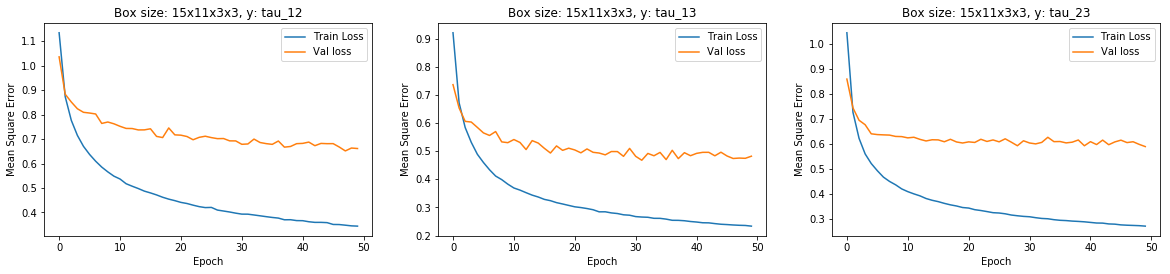

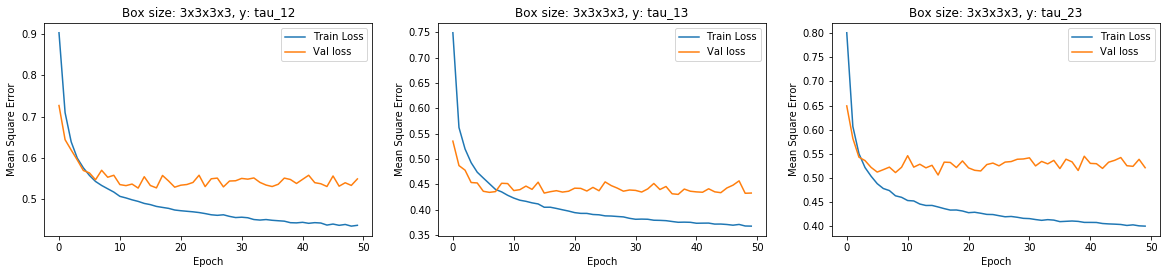

Box Size,Tau_12,Tau_13,Tau_23
7x7x7x3,0.8516,0.8976,0.8784
11x7x5x3,0.8384,0.8945,0.8742
15x11x3x3,0.8421,0.8968,0.8741
3x3x3x3,0.8281,0.8532,0.8415


In [8]:
out = [["Box Size", "Tau_12", "Tau_13", "Tau_23"]]
inputs = [(3,3,3), (5,3,2), (7,5,1), (1,1,1)]
i = 1

for shape in inputs:
    
    data, taus = generate_data(shape, x)
    
    activation = tf.nn.relu
    epochs = 50
    batch_size = 1000
    initializer = None
    input_shape = (data.shape[1], data.shape[2], data.shape[3], data.shape[4])
    val_split = 0.2

    fig = plt.figure(figsize = (20, 18))
    correlation = []
    for (y, name) in taus:
        mask =  np.random.rand(data.shape[0]) < 0.80
        x_train, x_test = data[mask,:,:,:,:], data[~mask,:,:,:,:]
        y_train, y_test = y[mask], y[~mask]

        model = DNN(activation, x_train, y_train, epochs, batch_size, input_shape, val_split, initializer)
        history, model = model.run_model()

        del x_train
        del y_train
        gc.collect()

        fig.add_subplot(4, len(taus), i)
        plt.plot(history.epoch, np.array(history.history['loss']), label = 'Train Loss')
        plt.plot(history.epoch, np.array(history.history['val_loss']), label = 'Val loss')
        plt.xlabel('Epoch')
        plt.ylabel('Mean Square Error')
        title = str("Box size: " + str(shape[0] * 2 + 1) + "x" + str(shape[1] * 2 + 1) + "x" + str(shape[2] * 2 + 1) + "x3"+ ", y: " + name)
        plt.title(title)
        plt.legend()

        y_pred = model.predict(x_test).flatten()
        y_true = y_test
        correlation.append(np.corrcoef(y_pred, y_true)[0, 1])

        del x_test
        del y_true
        del y_pred
        del y_test
        del model
        del y
        gc.collect()
        i += 1
    
    temp = str(shape[0] * 2 + 1) + "x" + str(shape[1] * 2 + 1) + "x" + str(shape[2] * 2 + 1) + "x3"
    out.append([temp, str(np.round(correlation[0], 4)), str(np.round(correlation[1], 4)), str(np.round(correlation[2], 4))])

plt.show()
display(HTML(tabulate.tabulate(out, tablefmt = 'html')))